In [6]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import csv
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import  KNeighborsClassifier

def clearData(data):
    # First changin ? with orderDate + Mean
    clearedDataFirst = [list(d) if list(d)[1] != "?" else [list(d)[0],(datetime.strptime(list(d)[0], '%Y-%m-%d') + timedelta(days=1)).strftime("%Y-%m-%d") ]  for d in zip(data['orderDate'], data['deliveryDate']) ]
    # Second changing 1990 with orderDate + Mean
    clearedTimeDataSecond = [d if datetime.strptime(list(d)[0], '%Y-%m-%d') <= datetime.strptime(list(d)[1], '%Y-%m-%d') else [d[0],(datetime.strptime(list(d)[0], '%Y-%m-%d') + timedelta(days=1)).strftime("%Y-%m-%d")] for d in clearedDataFirst]
    data["deliveryDate"] = [row[1] for row in clearedTimeDataSecond]

    # Clearing the birthdate data
    allDataFirstAgeChanged = [d if d != "?" else (datetime.strptime("2014-01-01", '%Y-%m-%d') - timedelta(days=48)).strftime('%Y-%m-%d') for d in data['dateOfBirth']   ]
    allDataAllAgeChanged = [d if datetime.strptime(d, '%Y-%m-%d') > datetime.strptime("1920-01-01", '%Y-%m-%d') and datetime.strptime(d, '%Y-%m-%d') < datetime.strptime("2000-01-01", '%Y-%m-%d') else (datetime.strptime("2014-01-01", '%Y-%m-%d') - timedelta(days=30*365.2)).strftime('%Y-%m-%d') for d in allDataFirstAgeChanged]
    data["dateOfBirth"] = allDataAllAgeChanged
    
    
    # salut
    salutArray = list(data["salutation"].unique())
    data["salutation"] = [salutArray.index(i) for i in data["salutation"]]
    
    # state
    stateArray = list(data["state"].unique())
    data["state"] = [stateArray.index(i) for i in data["state"]]
    
    accountAge = [((datetime.strptime("2014-01-01", '%Y-%m-%d')-datetime.strptime(d, '%Y-%m-%d'))/timedelta (days=1)) for d in data["creationDate"]]
    accountAgeF = np.array([d for d in accountAge])
    data["accountAge"] = accountAgeF
    
    ageNumArray = [((datetime.strptime("2014-01-01", '%Y-%m-%d')-datetime.strptime(d, '%Y-%m-%d'))/timedelta (days=1))/365 for d in data['dateOfBirth']]
    ageNumF = np.array([ d for d in ageNumArray])
    data["age"] = ageNumF
    
    
    return data

def calculateRisk(r0, r1):
    c = 1.49615
    return 1- ((r0**c + 50) / ((r0+r1)**c + 100))


def createFeautre(data, rDict, pDict, mDict, cDict):
    # Feature 1, if taken date > 10 1, else 0
    shipmentDateF = np.array([math.floor((datetime.strptime(list(d)[1], '%Y-%m-%d')-datetime.strptime(list(d)[0], '%Y-%m-%d')) / timedelta (days=1)) for d in zip(data['orderDate'], data['deliveryDate'])])

    # Feature 2 - specialDateChrismass, if order is close to speacial date and came late it is 1
    # Feature 3 - specialDateOthers, if order is close to speacial date and came late it is 1
    dateRepresentationOfData = [ [(int('%02d' % datetime.strptime(list(d)[0], '%Y-%m-%d').day),int('%02d' % datetime.strptime(list(d)[0], '%Y-%m-%d').month)), (int('%02d' % datetime.strptime(list(d)[1], '%Y-%m-%d').day),int('%02d' % datetime.strptime(list(d)[1], '%Y-%m-%d').month))] for d in zip(data['orderDate'], data['deliveryDate'])]
    specialDateChristmasF = np.array([1 if (d[0][0] > 14 and d[0][0] < 22 and d[0][1] == 12) and (d[1][0] >= 1 and d[1][1] >= 1) else 0 for d in dateRepresentationOfData])
    specialDateOthersF = np.array([1 if (d[0][0] > 3 and d[0][0] < 11 and d[0][1] == 5) and (d[1][0] >= 15 and d[1][1] >= 5) or (d[0][0] > 8 and d[0][0] < 14 and d[0][1] == 2) and (d[1][0] >= 18 and d[1][1] >= 2) else 0 for d in dateRepresentationOfData])

    # Feature 4 
    ageNummArray = [((datetime.strptime("2014-01-01", '%Y-%m-%d')-datetime.strptime(d, '%Y-%m-%d'))/timedelta (days=1))/365 for d in data['dateOfBirth']]
    ageNumF = np.array([ 0 if d < 35 else 1 for d in ageNummArray])
    
    # Feature 5
    accountAge = [((datetime.strptime("2014-01-01", '%Y-%m-%d')-datetime.strptime(d, '%Y-%m-%d'))/timedelta (days=1)) for d in data["creationDate"]]
    accountAgeF = np.array([0 if d < 450 else 1 for d in accountAge])
    
    # Feature 6 manufacturer id mean value
    manuReturnRateF = np.array([calculateRisk(mDict[str(d) + "-0"], mDict[str(d) + "-1"]) for d in data['manufacturerID'] ])


    # Feature 7 costumer id mean value
    userReturnRateF = np.array([calculateRisk(cDict[str(d) + "-0"], cDict[str(d) + "-1"]) for d in data['customerID'] ])


    
    # Feature 8 risk
    rZeroF = np.array([calculateRisk(rDict[str(d) + "-0"], rDict[str(d) + "-1"]) for d in data['itemID'] ])
    
    # Feature 9 price
    priceF = np.array([list(d)[1]/pDict[str(list(d)[0])] for d in zip(data['itemID'],data['price'])])
    
    
    

            
        
    
    return  np.vstack((shipmentDateF, specialDateChristmasF, specialDateOthersF, ageNumF, accountAgeF, manuReturnRateF, userReturnRateF, rZeroF, priceF, data['manufacturerID'], data['customerID'],data['itemID'])).T
    

In [7]:
data = clearData(pd.read_csv('train.txt', sep=","))

In [8]:
rDict = {}
for i in range(3705):
    rDict[str(i) + "-0"] = 0
    rDict[str(i) + "-1"] = 0
grouped_df = data.groupby(['itemID', 'returnShipment'])['itemID', 'returnShipment']
for key, item in grouped_df:
    rDict[str(key[0]) + "-" + str(key[1])] = len(grouped_df.get_group(key))
    
    
pDict = {}
for i in range(4000):
    pDict[str(i)] = (1, 1)    
grouped_df = data.groupby(['itemID', 'price'])['itemID', 'price']

for key, item in grouped_df:
    pDict[str(key[0])] = (pDict[str(key[0])][0]+key[1], pDict[str(key[0])][1] + 1)


for key, item in pDict.items():
    if item[1] == 1:
        pDict[key] = item[0]
    if item[1] != 1:
        pDict[key] = item[0]/(item[1]-1)
    

mDict = {}
for i in range(200):
    mDict[str(i) + "-0"] = 0
    mDict[str(i) + "-1"] = 0
grouped_df = data.groupby(['manufacturerID', 'returnShipment'])['manufacturerID', 'returnShipment']
for key, item in grouped_df:
    mDict[str(key[0]) + "-" + str(key[1])] = len(grouped_df.get_group(key))
    
    
aaDict = {}
for i in range(200):
    mDict[str(i) + "-0"] = 0
    mDict[str(i) + "-1"] = 0
grouped_df = data.groupby(['accountAge', 'returnShipment'])['accountAge', 'returnShipment']
for key, item in grouped_df:
    mDict[str(key[0]) + "-" + str(key[1])] = len(grouped_df.get_group(key))
    
    
cDict = {}
for i in range(92000):
    cDict[str(i) + "-0"] = 0
    cDict[str(i) + "-1"] = 0
grouped_df = data.groupby(['customerID', 'returnShipment'])['customerID', 'returnShipment']
for key, item in grouped_df:
    cDict[str(key[0]) + "-" + str(key[1])] = len(grouped_df.get_group(key))

In [9]:
# Creating train matrix
trainMatrix = createFeautre(data, rDict, pDict, mDict, cDict)
# Creating label array
labelArray = np.array(data['returnShipment'])



In [10]:
testData =  clearData( pd.read_csv('test.txt', sep=","))

In [11]:
rDictTest = {}
for i in range(4000):
    rDictTest[str(i) + "-0"] = 0.5
    rDictTest[str(i) + "-1"] = 0.5

for key, item in rDict.items():
    rDictTest[key] = item

In [12]:
testMatrix = createFeautre(testData, rDictTest, pDict, mDict, cDict)

In [13]:
# Logistic
logisticRegr = LogisticRegression()
logisticRegr.fit(trainMatrix, labelArray)
predictLogistic = logisticRegr.predict_proba(testMatrix)
print(sorted([e[1] for e in predictLogistic]))

[0.011734374721702362, 0.013288626021990109, 0.014785845046592486, 0.01585341952540249, 0.0161860552985374, 0.01787219119251975, 0.01787219119251975, 0.017970251295415195, 0.017970251295415195, 0.01897560583002866, 0.02039426294533052, 0.020878248572723055, 0.021012601274485055, 0.021791341605076293, 0.022148104611605657, 0.023742753383384583, 0.02387731727207261, 0.024771357605799106, 0.025381403067814185, 0.026128054578762286, 0.026128054578762286, 0.02711734935026002, 0.027245686231599536, 0.027832377734293545, 0.028117910513131325, 0.028230940597036507, 0.028281122428275674, 0.028408501156744922, 0.028444499717978872, 0.02867311973535128, 0.02906653860040334, 0.030448704859613842, 0.030448704859613842, 0.030552423175036474, 0.03154726166465746, 0.03187374526165049, 0.03212409423507882, 0.032809844569397784, 0.03281875883864717, 0.03356784281060561, 0.033700465434183396, 0.03374189520920256, 0.03374189520920256, 0.03401918176258804, 0.034123506757527795, 0.03439083937003129, 0.03501

In [14]:
# Gauss
clf = GaussianNB()
clf.fit(trainMatrix, labelArray)
predictGauss = clf.predict_proba(testMatrix)
print(sorted([e[1] for e in predictGauss]))


[1.7430404193031323e-35, 1.7430404193031323e-35, 6.637151999508969e-13, 0.4124795209879856, 0.41373034665296, 0.41578897405899445, 0.4159091178388633, 0.4159091178388633, 0.41627785624905833, 0.416299362544234, 0.4170626496349351, 0.4176570722263066, 0.4176570722263066, 0.4180940711361734, 0.4181915766531508, 0.4183408550572723, 0.4183408550572723, 0.4189063123798949, 0.41904926509930607, 0.4194527847802383, 0.4194527847802383, 0.41946852897006953, 0.419655004352332, 0.42023717521954307, 0.420329835456849, 0.42035133703103306, 0.4203655031189083, 0.4204363983365806, 0.420594967497971, 0.4205953348500127, 0.42064292071393883, 0.4207760499226109, 0.4209097022845431, 0.42101349069726574, 0.4210141970871984, 0.42127234349001175, 0.4213469429486158, 0.4214056451888105, 0.4215782156451488, 0.4216525387103675, 0.4217175620816801, 0.4219080167282592, 0.4221368039180868, 0.4221750628650829, 0.42221355628926666, 0.4223744242568229, 0.422403869478923, 0.422403869478923, 0.42246408931269036, 0.422

In [15]:
# RF
rf = RandomForestClassifier()
rf.fit(trainMatrix, labelArray)
predictRF = rf.predict_proba(testMatrix)
print(sorted([e[1] for e in predictRF]))


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [16]:
# decision tree
dtc = DecisionTreeClassifier()
dtc.fit(trainMatrix, labelArray)
predictdtc = dtc.predict_proba(testMatrix)
print(sorted([e[1] for e in predictdtc]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [33]:

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(learning_rate=0.1)
clf.fit(trainMatrix, labelArray)
predictclf = clf.predict(testMatrix)

In [37]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(max_iter=1000)
sgd.fit(trainMatrix, labelArray)
predictsgd = sgd.predict(testMatrix)

In [38]:
from sklearn.metrics import accuracy_score
trainErrorRF = rf.predict(trainMatrix)
trainErrorMLP = clf.predict(trainMatrix)
trainErrorSGD = sgd.predict(trainMatrix)

print(accuracy_score(labelArray, trainErrorRF))
print(accuracy_score(labelArray, trainErrorMLP))
print(accuracy_score(labelArray, trainErrorSGD))

0.9438901499089571
0.7409206555087177
0.48261247328993206


In [92]:
myData = [["orderItemID", "returnShipment"]] + [[str(i+1), str(e[1])] for i,e in enumerate(predictdtc)]

myFile = open('predictdtc.csv', 'w')
with myFile:
    writer = csv.writer(myFile)
    writer.writerows(myData)
     
print("Writing complete")

Writing complete


In [14]:
pd.to_numeric(data, errors='ignore')


TypeError: arg must be a list, tuple, 1-d array, or Series

In [356]:
# -------------------------------------------------

In [23]:
colorArray = list(data["color"].unique())
z = [colorArray.index(i) for i in data["color"]]

In [24]:
z

[0,
 1,
 2,
 3,
 4,
 5,
 4,
 5,
 6,
 3,
 7,
 4,
 4,
 1,
 7,
 8,
 3,
 3,
 9,
 10,
 11,
 3,
 5,
 12,
 5,
 6,
 4,
 5,
 9,
 3,
 5,
 13,
 11,
 11,
 10,
 7,
 3,
 4,
 4,
 4,
 14,
 2,
 11,
 11,
 4,
 12,
 4,
 15,
 6,
 16,
 1,
 17,
 7,
 18,
 5,
 11,
 4,
 11,
 19,
 20,
 19,
 21,
 22,
 5,
 22,
 5,
 4,
 7,
 17,
 4,
 12,
 3,
 17,
 17,
 6,
 3,
 3,
 5,
 4,
 5,
 5,
 4,
 1,
 5,
 3,
 1,
 12,
 12,
 14,
 23,
 18,
 16,
 5,
 24,
 24,
 14,
 1,
 1,
 14,
 6,
 25,
 4,
 4,
 4,
 26,
 3,
 4,
 5,
 9,
 9,
 5,
 5,
 12,
 17,
 11,
 11,
 23,
 3,
 3,
 3,
 11,
 6,
 11,
 0,
 27,
 28,
 29,
 17,
 9,
 4,
 12,
 12,
 4,
 0,
 4,
 0,
 0,
 10,
 0,
 5,
 17,
 7,
 3,
 9,
 4,
 12,
 5,
 11,
 3,
 12,
 12,
 7,
 4,
 5,
 2,
 3,
 4,
 10,
 2,
 23,
 9,
 0,
 4,
 6,
 3,
 24,
 6,
 6,
 12,
 12,
 4,
 6,
 25,
 12,
 11,
 17,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 4,
 23,
 6,
 4,
 4,
 4,
 4,
 6,
 6,
 12,
 30,
 23,
 17,
 11,
 6,
 17,
 12,
 11,
 4,
 5,
 4,
 9,
 23,
 23,
 9,
 12,
 31,
 1,
 23,
 1,
 4,
 5,
 4,
 11,
 12,
 4,
 15,
 3,
 16,
 3,
 26,
 4,
 12,
 

In [13]:
max(testData["customerID"])

91911

In [ ]:
# Feature 1, if taken date > 10 1, else 0
shipmentDateF = np.array([math.floor((datetime.strptime(list(d)[1], '%Y-%m-%d')-datetime.strptime(list(d)[0], '%Y-%m-%d')) / timedelta (days=1)) for d in zip(data['orderDate'], data['deliveryDate'])])

# Feature 2 - specialDateChrismass, if order is close to speacial date and came late it is 1
# Feature 3 - specialDateOthers, if order is close to speacial date and came late it is 1
dateRepresentationOfData = [ [(int('%02d' % datetime.strptime(list(d)[0], '%Y-%m-%d').day),int('%02d' % datetime.strptime(list(d)[0], '%Y-%m-%d').month)), (int('%02d' % datetime.strptime(list(d)[1], '%Y-%m-%d').day),int('%02d' % datetime.strptime(list(d)[1], '%Y-%m-%d').month))] for d in zip(data['orderDate'], data['deliveryDate'])]
specialDateChristmasF = np.array([1 if (d[0][0] > 14 and d[0][0] < 22 and d[0][1] == 12) and (d[1][0] >= 1 and d[1][1] >= 1) else 0 for d in dateRepresentationOfData])
specialDateOthersF = np.array([1 if (d[0][0] > 3 and d[0][0] < 11 and d[0][1] == 5) and (d[1][0] >= 15 and d[1][1] >= 5) or (d[0][0] > 8 and d[0][0] < 14 and d[0][1] == 2) and (d[1][0] >= 18 and d[1][1] >= 2) else 0 for d in dateRepresentationOfData])

# Feature 4 
ageNummArray = [((datetime.strptime("2014-01-01", '%Y-%m-%d')-datetime.strptime(d, '%Y-%m-%d'))/timedelta (days=1))/365 for d in data['dateOfBirth']]
ageNumF = np.array([ 0 if d < 40 else 1 for d in ageNummArray])

# Feature 5
accountAge = [((datetime.strptime("2014-01-01", '%Y-%m-%d')-datetime.strptime(d, '%Y-%m-%d'))/timedelta (days=1))/365 for d in data["creationDate"]]
accountAgeF = np.array([0 if d < 40 else 1 for d in accountAge])

# Feature 6 manufacturer id mean value
manuReturnRateF = np.array([(mDict[str(d) + "-1"] + 5)/(mDict[str(d) + "-1"] + 10 + mDict[str(d) + "-0"] ) for d in data['manufacturerID'] ])


# Feature 7 costumer id mean value
userReturnRateF = np.array([(cDcit[str(d) + "-1"] + 5)/(cDcit[str(d) + "-1"] + 10 + cDcit[str(d) + "-0"] ) for d in data['customerID'] ])



# Feature 8 risk
rZeroF = np.array([(rDict[str(d) + "-1"] + 5)/(rDict[str(d) + "-1"] + 10 + rDict[str(d) + "-0"] ) for d in data['itemID'] ])

# Feature 9 price
priceF = np.array([list(d)[1]/pDict[str(list(d)[0])] for d in zip(data['itemID'],data['price'])])

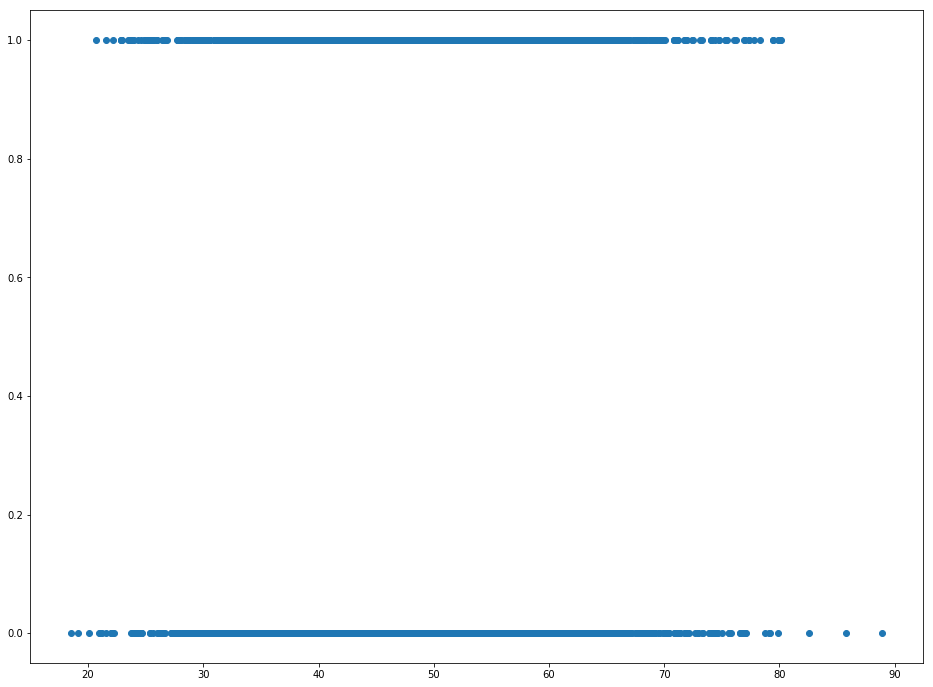

In [28]:
import matplotlib.pyplot as plt
data = data.sample(n=10000)
plt.figure(figsize=(16, 12))
# evenly sampled time at 200ms intervals
Y = np.array(data["returnShipment"])
ageNummArray = [((datetime.strptime("2014-01-01", '%Y-%m-%d')-datetime.strptime(d, '%Y-%m-%d'))/timedelta (days=1))/365 for d in data['dateOfBirth']]
X = np.array([ d for d in ageNummArray])
# red dashes, blue squares and green triangles
plt.plot(X, Y, linestyle="",marker="o")
plt.show()

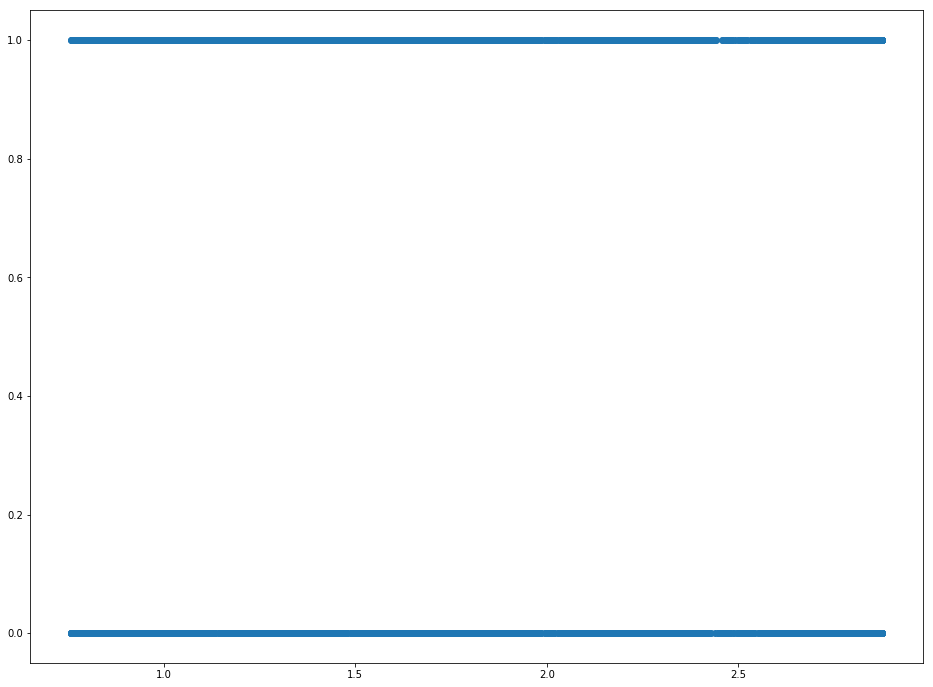

In [30]:
plt.figure(figsize=(16, 12))
# evenly sampled time at 200ms intervals
Y = np.array(data["returnShipment"])
accountAge = [((datetime.strptime("2014-01-01", '%Y-%m-%d')-datetime.strptime(d, '%Y-%m-%d'))/timedelta (days=1))/365 for d in data["creationDate"]]
X = np.array([d for d in accountAge])
# red dashes, blue squares and green triangles
plt.plot(X, Y, linestyle="",marker="o")
plt.show()

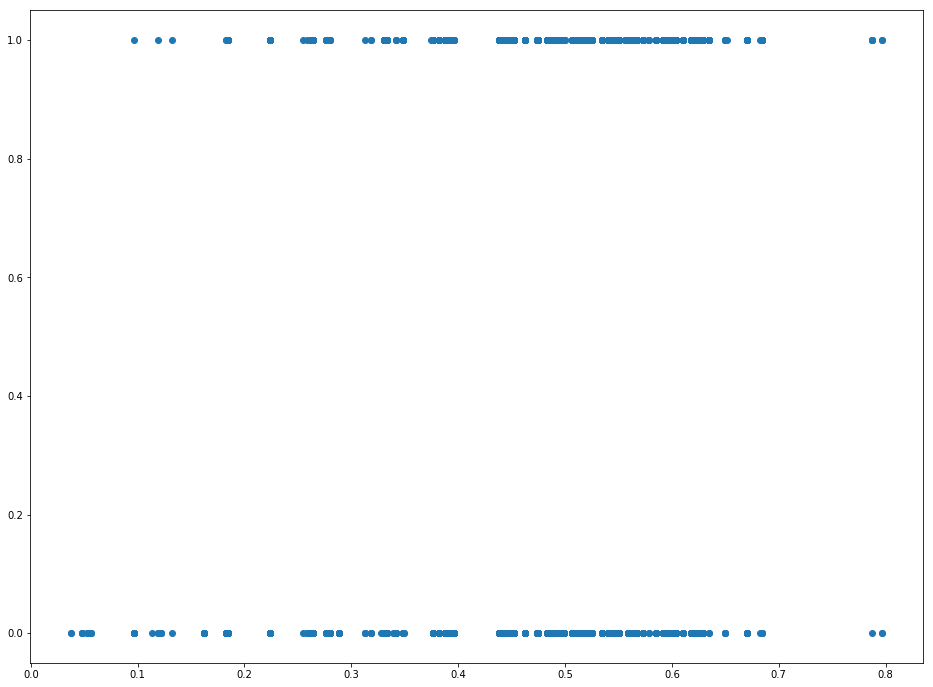

In [31]:
plt.figure(figsize=(16, 12))
# evenly sampled time at 200ms intervals
Y = np.array(data["returnShipment"])
X = np.array([(mDict[str(d) + "-1"] + 5)/(mDict[str(d) + "-1"] + 10 + mDict[str(d) + "-0"] ) for d in data['manufacturerID'] ])
# red dashes, blue squares and green triangles
plt.plot(X, Y, linestyle="",marker="o")
plt.show()

In [43]:
asdf = np.array([(cDict[str(d) + "-1"] + 5)/(cDict[str(d) + "-1"] + 10 + cDict[str(d) + "-0"] ) for d in data['manufacturerID'] ])

In [44]:
min(asdf)

0.2222222222222222

In [45]:
max(asdf)

0.813953488372093

In [55]:
manuReturnRateF = np.array([calculateRisk(mDict[str(d) + "-0"], mDict[str(d) + "-1"]) for d in data['manufacturerID'] ])